In [153]:
from skimage.external.tifffile import imread
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

from scipy.ndimage.measurements import center_of_mass

import ipywidgets as widgets

In [150]:
bigDir=r'S:\CookLab\Liu\20190816_organizedData_MCM_loading'
file=f'{bigDir}\\new dataset\signals_new_v4.csv'
data=pd.read_csv(file)

In [151]:
data.head()

,Unnamed: 0,file,original cell name,movie,last frame movie position x,last frame movie position y,ab1 (MCM),ab1 ch,ab2 (heterochromatin),ab2 ch,...,nuc_DAPI_het,inner_DAPI_het,outer_DAPI_het,nuc_DAPI_eu,inner_DAPI_eu,outer_DAPI_eu,day,decon,p_age,mol_age_mod
0,0,20191203_cell-01.czi,20191125-01-20,191125pcnat_dhbr_cdc6vxy01,1552.152,240.479,MCM3,1,HP1beta,2,...,1.812075e+09,1.086345e+09,725729186.0,4.615195e+09,1.007696e+09,3.607499e+09,d20191203,False,NaN,1.373
1,1,20191203_cell-03.czi,20191125-01-25,191125pcnat_dhbr_cdc6vxy01,1650.585,324.968,MCM3,1,HP1beta,2,...,1.229128e+09,5.907975e+08,638330656.0,2.382242e+09,2.544991e+08,2.127743e+09,d20191203,False,1.500000,0.226
2,2,20191203_cell-05.czi,20191125-01-36,191125pcnat_dhbr_cdc6vxy01,1705.099,468.246,MCM3,1,HP1beta,2,...,1.336272e+09,8.335653e+08,502707049.0,2.233975e+09,2.555882e+08,1.978387e+09,d20191203,False,2.166667,0.632
3,3,20191203_cell-08.czi,20191125-01-41,191125pcnat_dhbr_cdc6vxy01,332.674,553.990,MCM3,1,HP1beta,2,...,9.643314e+08,5.258328e+08,438498603.0,2.153495e+09,3.529459e+08,1.800549e+09,d20191203,False,5.833333,0.759
4,4,20191203_cell-11.czi,20191125-01-54,191125pcnat_dhbr_cdc6vxy01,647.356,843.150,MCM3,1,HP1beta,2,...,9.153324e+08,3.707237e+08,544608651.0,2.008052e+09,3.305668e+08,1.677485e+09,d20191203,False,6.666667,0.325


In [209]:
# Progress Bar for the function
i=0
progBar=widgets.IntProgress(
    value=i,
    min=0,
    max=len(data),
    step=1,
    description='Progress:',
    orientation='horizontal'
)
display(progBar)

for i,cell in data.iterrows():

    ## open tiff image of a cell
    ### if the file is not found in the directory, trying to change the file extension 
    #### this is because there are some file files that are saved as tiff image 
    
    nucleusMaskPath = cell.path.replace('Z:','S:')
    nucleusMaskPath = nucleusMaskPath.replace('data_tiff','segmentation_nucleus_Otsu')
    nucleusMaskPath = nucleusMaskPath.replace('.tif','_nucleus.tif')
    try:
        nucMask=imread(nucleusMaskPath)
    except:
        nucleusMaskPath=nucleusMaskPath.replace('.tiff','.tif')
        nucMask=imread(nucleusMaskPath)
    
    #######################################################################
    # create onion masks
    
    # find center of mass

    nucMask = nucMask/255
    cm = np.rint(np.array(center_of_mass(nucMask)))

    # find coordinates
    myCoord = np.array(np.nonzero(nucMask)).T

    # create output image
    newMask = np.zeros(nucMask.shape)

    # create concentric masks
    numLayers=20

    newMask[nucMask>0] = numLayers
    
    for i in np.arange(numLayers-1,0,-1):

        # shift coordinates and create a small object
        myCoordNew = np.rint(((myCoord-cm)*(i/numLayers)) + cm).astype(int) 

        newMask[tuple(myCoordNew.T)] = i
        
    newMask[nucMask==0] = 0
        
    #######################################################################
    # save onion masks
    ## saving image files
    newSegFolder = os.path.dirname(cell.path).replace('data_tiff',f'onion{numLayers}_nuc_mask')
    newSegFolder = newSegFolder.replace('Z:','S:')
    try:
        os.mkdir(newSegFolder)
    except:
        pass
    maskFile = os.path.basename(cell.path).replace('.tif',f'_onion{numLayers}.tif')
    tifffile.imsave(os.path.join(newSegFolder,maskFile), newMask.astype('uint8'))

    progBar.value=progBar.value+1    

IntProgress(value=0, description='Progress:', max=150)

<IPython.core.display.Javascript object>


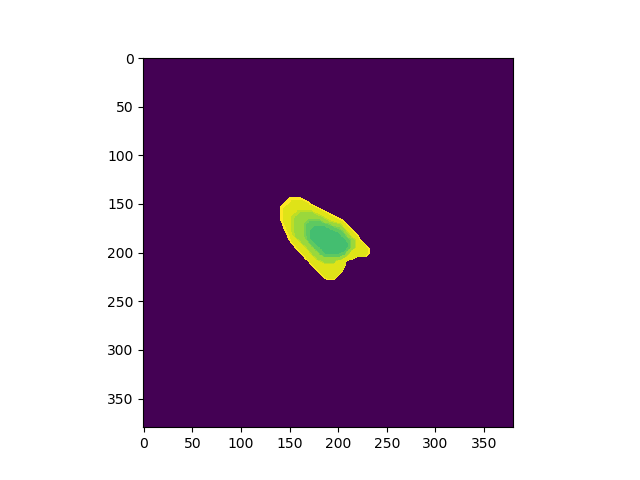

In [210]:
%matplotlib notebook

plt.imshow(newMask[15,:,:])

<IPython.core.display.Javascript object>


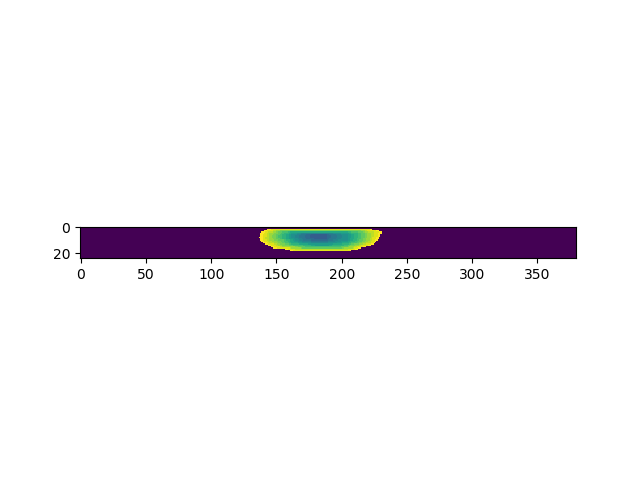

In [211]:
%matplotlib notebook

plt.imshow(newMask[:,180,:])